In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

# Preprocessing

In [2]:
# Loading from github
df_case = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

In [3]:
# Adding day and minute data

df_case["day"] = df_case.date.apply(lambda x: str(pd.Timestamp(x).month) +"-"+ str(pd.Timestamp(x).day))
df_case["minute"] = df_case.date.apply(lambda x: (pd.Timestamp(x).minute))

In [4]:
df_case.head()

Unnamed: 0  availiable_docks                 date    weekday  hour   day  \
0           0                 8  2020-01-15 10:17:00  Wednesday    10  1-15   
1           1                 8  2020-01-15 10:18:00  Wednesday    10  1-15   
2           2                 7  2020-01-15 10:19:00  Wednesday    10  1-15   
3           3                 8  2020-01-15 10:20:00  Wednesday    10  1-15   
4           4                 8  2020-01-15 10:21:00  Wednesday    10  1-15   

   minute  
0      17  
1      18  
2      19  
3      20  
4      21

In [5]:
# Pipe for having 30 min before an hour and 30 min after

# variable
start_hour = 9
minute_around = 30
day_list = df_case.day.unique()

In [6]:
df_conso = pd.DataFrame(columns=df_case.columns)
for i in day_list:
    df_temp_lower = df_case[(df_case["day"] == i) & (df_case["hour"] == (start_hour-1)) & (df_case["minute"] > minute_around)]
    df_temp_upper = df_case[(df_case["day"] == i) & (df_case["hour"] == start_hour) & (df_case["minute"] <= minute_around)]
    df_temp = pd.concat([df_temp_lower, df_temp_upper])
    df_conso = pd.concat([df_conso, df_temp])
df_conso = df_conso.reset_index(drop="True")

In [7]:
df_conso.head()

Unnamed: 0 availiable_docks                 date   weekday hour   day minute
0       1251               15  2020-01-16 08:31:00  Thursday    8  1-16     31
1       1252               15  2020-01-16 08:32:00  Thursday    8  1-16     32
2       1253               15  2020-01-16 08:33:00  Thursday    8  1-16     33
3       1254               14  2020-01-16 08:34:00  Thursday    8  1-16     34
4       1255               14  2020-01-16 08:35:00  Thursday    8  1-16     35

# Second processing pipeline

In [8]:
df_cycle = df_conso[["availiable_docks", "date"]]

In [9]:
df_cycle["availiable_docks"] = df_cycle["availiable_docks"].astype(int)

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_cycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
availiable_docks    600 non-null int64
date                600 non-null object
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [11]:
# Saving time for later
save_time = df_cycle.date

In [12]:
# Removing all useless columns
dataset = np.array(df_cycle["availiable_docks"])

In [13]:
dataset[0:10]

array([15, 15, 15, 14, 14, 14, 14, 14, 14, 13])

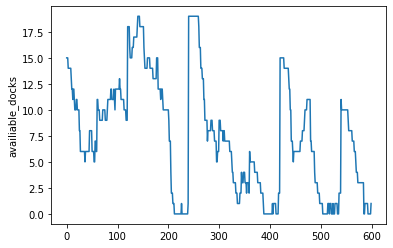

In [46]:
_ = sns.lineplot(data=df_cycle, x=df_cycle.index, y="availiable_docks")

In [15]:
# Variable definition
split_ratio = 9/10

In [16]:
# Doing a slit of aust between train and test
train = dataset[0:int(round(len(dataset)*split_ratio,0))]
test = dataset[int(round(len(dataset)*split_ratio,0)):]

In [17]:
print("Length of dataset:", len(dataset))
print("Length of train:", len(train))
print("Length of test:", len(test))
print("Check:", len(dataset)-len(train)-len(test))

Length of dataset: 600
Length of train: 540
Length of test: 60
Check: 0


# Modelling

In [18]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [19]:
# OK
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', 'additive', None]
    d_params = [True, False]
    s_params = ['add', 'mul', 'additive', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [20]:
# Creating list of configuration possible
cfg_list = exp_smoothing_configs(seasonal=[60])

# Sample
cfg_list[:5]

[['add', True, 'add', 60, True, True],
 ['add', True, 'add', 60, True, False],
 ['add', True, 'add', 60, False, True],
 ['add', True, 'add', 60, False, False],
 ['add', True, 'mul', 60, True, True]]

In [21]:
# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            t,d,s,p,b,r = configurations[i]
            # define model
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
            # fit model
            # make one step forecast
            pred = model.predict(start=len(train)+1,end=len(test)+len(train))
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            pass
    print(best_config)
    print(best_rmse)
    return(best_config)

In [22]:
best_parameters = exp_smoothing_forecast_grid_search(train, test, cfg_list)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: Converge

['add', True, 'add', 60, False, False]
2.442898217465575


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [23]:
best_parameters

['add', True, 'add', 60, False, False]

# Best model

In [24]:
t,d,s,p,b,r = best_parameters

# define model
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
# make one step forecast
pred = model.predict(start=len(train)+1,end=len(test)+len(train))
temp_indicator = measure_rmse(test,pred)
print(temp_indicator)

2.442898217465575


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [35]:
t,d,s,p,b,r = best_parameters

# define model
model2 = ExponentialSmoothing(dataset, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
# make one step forecast
pred = model2.predict(1,end=len(dataset))
temp_indicator = measure_rmse(dataset,pred)
print(temp_indicator)

0.9248639131701868


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


# Graphic visualisation 1

In [27]:
df = pd.DataFrame(columns=["actual","forecast"])
df.actual = (np.concatenate((train,test), axis = 0))
df.forecast = (np.concatenate((train,pred), axis = 0))
df.head()

actual  forecast
0      15      15.0
1      15      15.0
2      15      15.0
3      14      14.0
4      14      14.0

In [ ]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df.index, y="forecast",data=df, color="red")
sns.lineplot(x=df.index, y="actual",data=df, color="green")


plt.show()

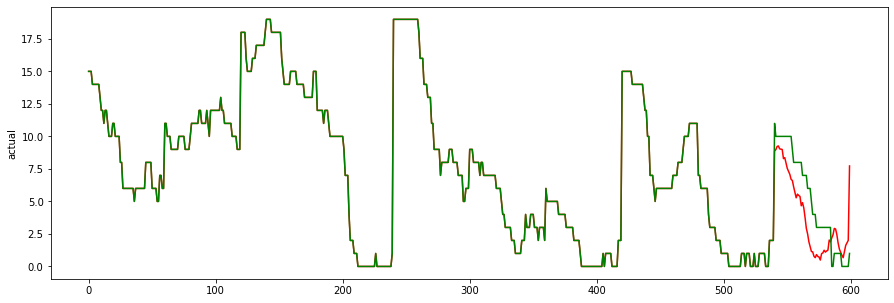

In [28]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df.index, y="forecast",data=df, color="red")
sns.lineplot(x=df.index, y="actual",data=df, color="green")


plt.show()

# Graphic visualisation 2

In [29]:
# prediction the dataset + 30 minutes
pred2 = model.predict(start=(len(test)+len(train)+1), end=(len(test)+len(train)+30))

In [32]:
df2 = pd.DataFrame(columns=["actual","forecast"])
df2.actual = (np.concatenate((train,test, (np.zeros(30)+test[-1:])), axis = 0))
df2.forecast = (np.concatenate((train,pred,pred2), axis = 0))
df2.head()

actual  forecast
0    15.0      15.0
1    15.0      15.0
2    15.0      15.0
3    14.0      14.0
4    14.0      14.0

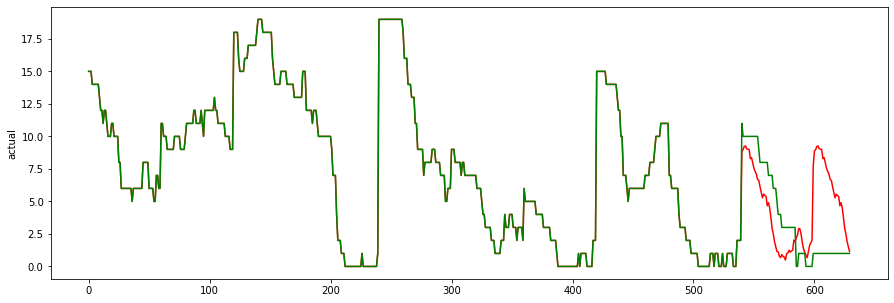

In [33]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df2.index, y="forecast",data=df2, color="red")
sns.lineplot(x=df2.index, y="actual",data=df2, color="green")


plt.show()

# With optimised model

In [38]:
# prediction the dataset + 30 minutes
pred3 = model2.predict(start=(len(dataset)+1), end=(len(dataset)+30))

In [39]:
df3 = pd.DataFrame(columns=["actual","forecast"])
df3.actual = (np.concatenate((dataset, (np.zeros(30)+dataset[-1:])), axis = 0))
df3.forecast = (np.concatenate((dataset, pred3), axis = 0))
df3.head()

actual  forecast
0    15.0      15.0
1    15.0      15.0
2    15.0      15.0
3    14.0      14.0
4    14.0      14.0

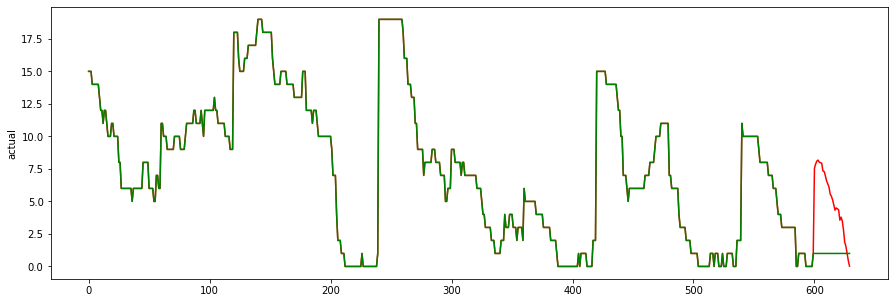

In [44]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df3.index, y="forecast",data=df3, color="red")
sns.lineplot(x=df3.index, y="actual",data=df3, color="green")


plt.show()

# Curve comparison


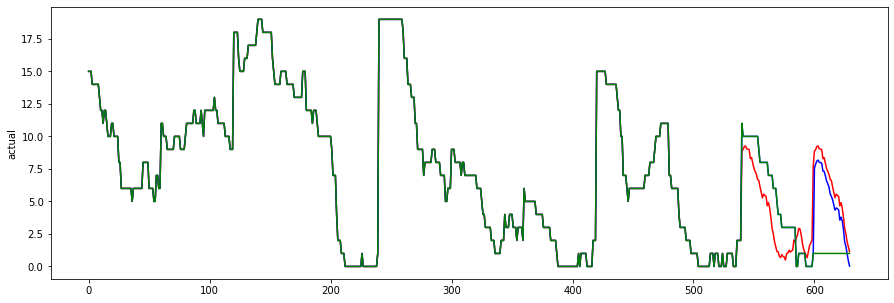

In [42]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df2.index, y="forecast",data=df2, color="red")
sns.lineplot(x=df3.index, y="forecast",data=df3, color="blue")
sns.lineplot(x=df3.index, y="actual",data=df3, color="green")


plt.show()

Improvements:
- algo for the right periode
- indexing with time

In [ ]:
# Loading data temperature
data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
dataset = pd.Series(data, index)

In [69]:
index_date = pd.date_range(start=df_cycle.date[0], end=df_cycle.shape[0],freq="T")

In [70]:
index_date

DatetimeIndex([], dtype='datetime64[ns]', freq='T')

In [71]:
df_cycle.shape

(600, 2)

In [72]:
df = pd.DataFrame(columns=["actual","forecast"], index = index_date)
df.actual = (np.concatenate((train,test), axis = 0))
df.forecast = (np.concatenate((train,pred), axis = 0))
df.head()

ValueError: Length of values does not match length of index

In [73]:
df = pd.DataFrame(columns=["actual","forecast"], index = index_date)
df.actual = (np.concatenate((train,test), axis = 0))

In [75]:
df

actual forecast
0        15      NaN
1        15      NaN
2        15      NaN
3        14      NaN
4        14      NaN
..      ...      ...
595       0      NaN
596       0      NaN
597       0      NaN
598       0      NaN
599       1      NaN

[600 rows x 2 columns]

In [77]:
len(np.concatenate((train,pred), axis = 0))

1140